# Big idea

I've been looking at plots of (Q=2) stars' JHK Stetson index as a function of K magnitude, and I think the threshold separating "variable" from "nonvariable" should be considered a function of magnitude: it drops to lower values for objects fainter than about K=15. (This corresponds more or less precisely to where the shift between "systematic noise dominates" to "random photon noise dominates", which I think makes sense as a data-grounded justification for having such a 'floating' variability criterion.)

I therefore want to try the following experiment:

1. select the spatial region of each survey which has the fewest variable stars (generally, this means excluding the center; depends on the geometry of each cluster)
2. do stats on each half- or quarter-magnitude bin for Q=2 stars' JHK Stetson indices (plot them first!) and find where (e.g.) 99% of stars are contained
3. draw a line, save that value, that's our variability criterion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
%run ../variability_selection.py

In [3]:
from wuvars.data import spreadsheet

spread = spreadsheet.load_v2()


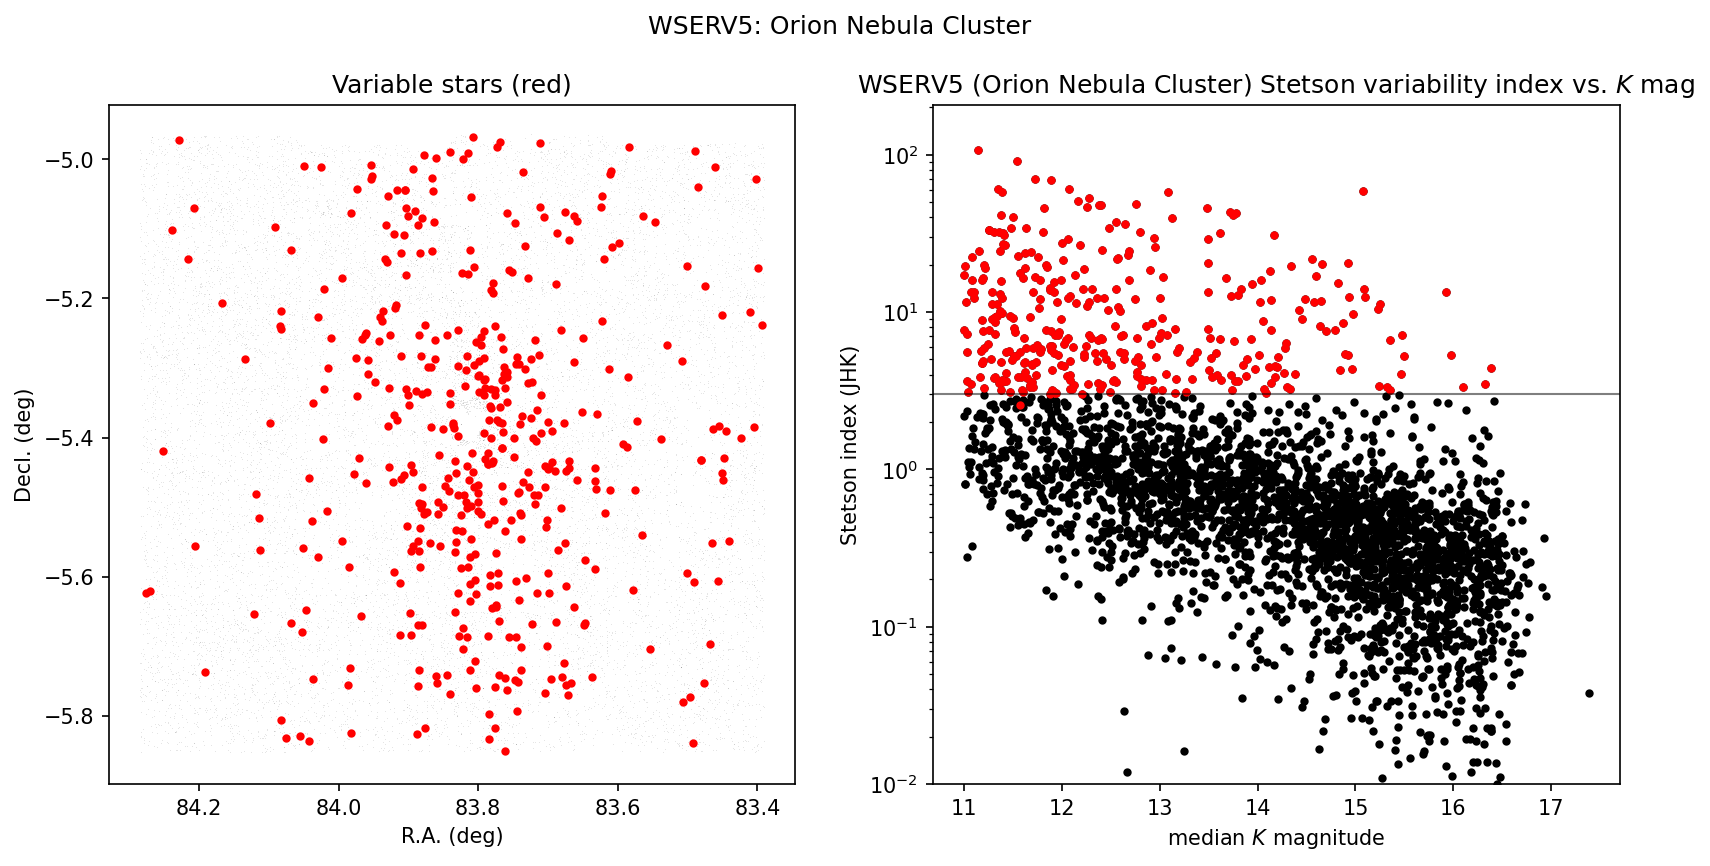

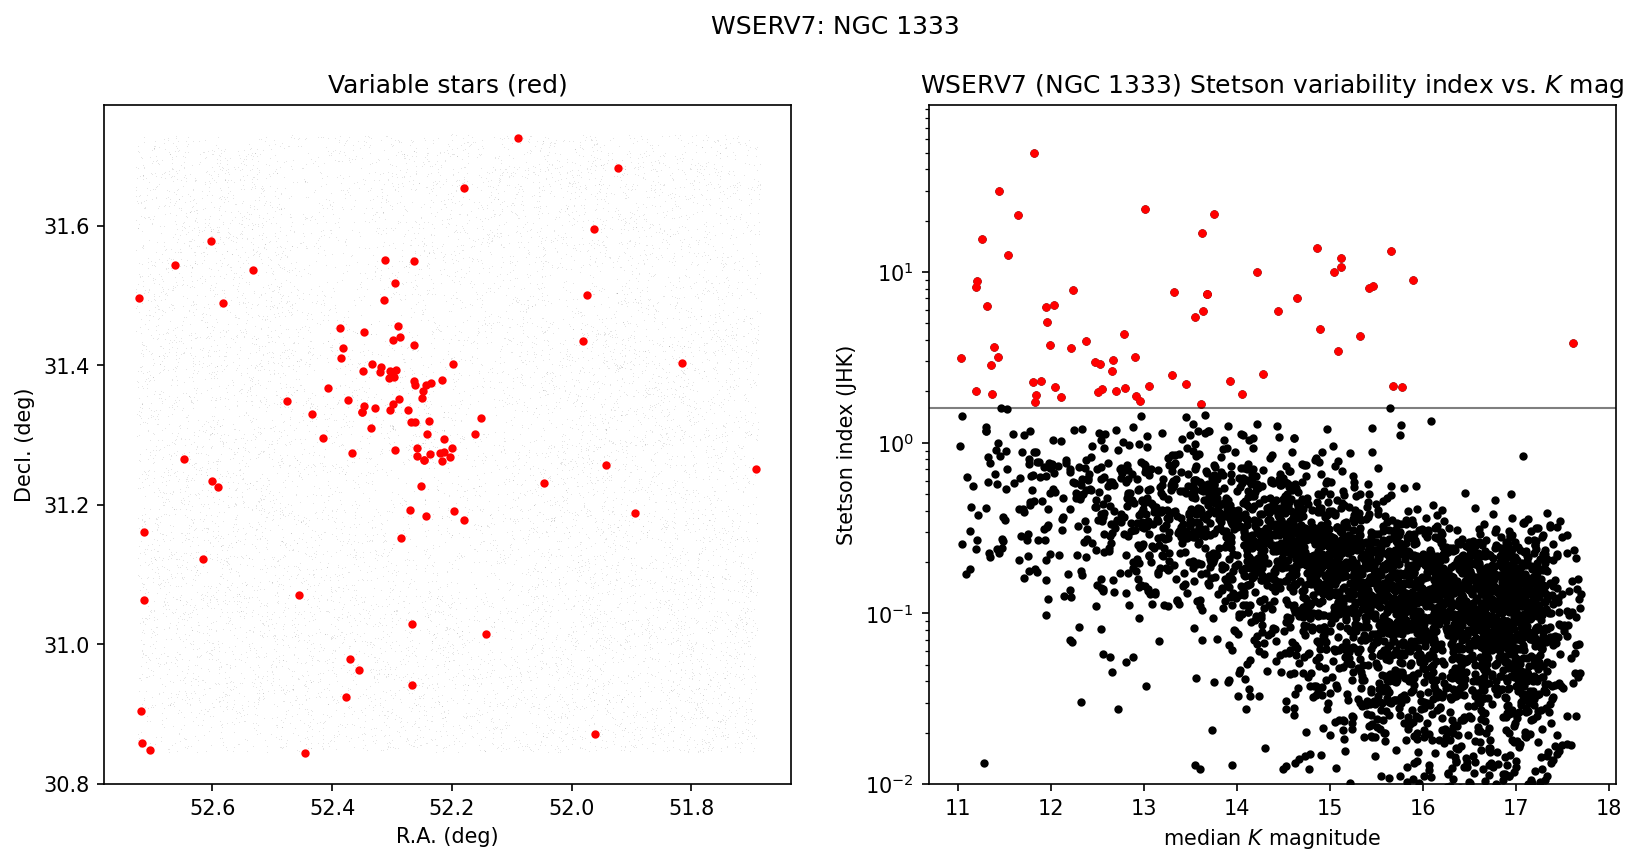

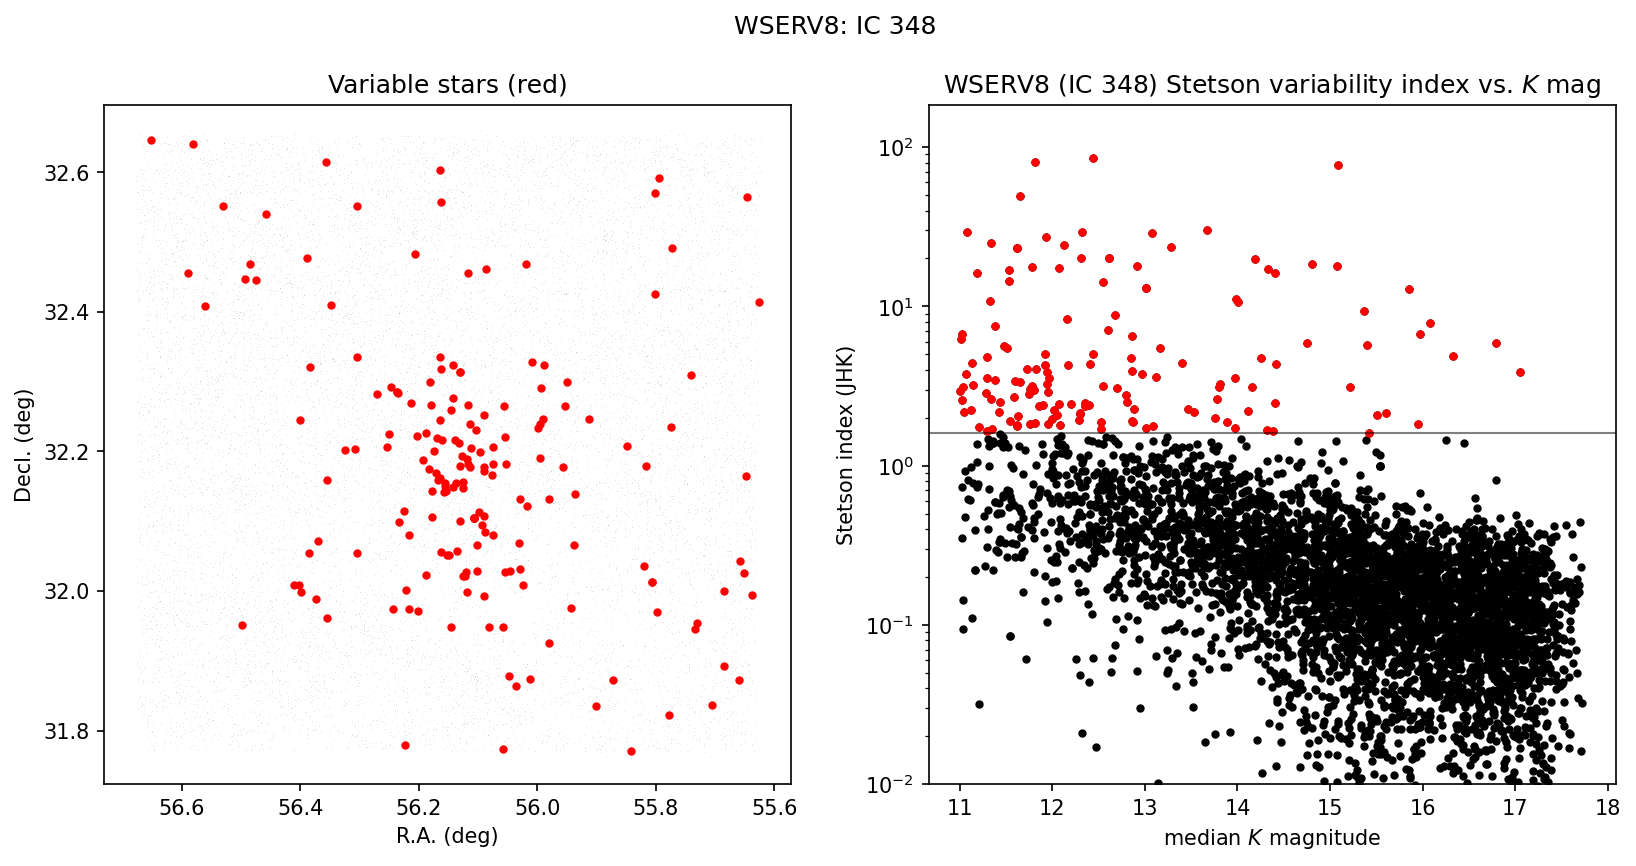

In [13]:
wserv_ids = [1, 5, 7, 8, 11]

# n_obs_list = [130, 120, 171, 85, 110]

n_min_list = [60, 35, 80, 55, 65]
n_max_list = [100, 90, 160, 80, 100]

min_Stetson_list = [2, 3, 1.6, 1.6, 4]

SFR_names = ["Cyg OB7", "Orion Nebula Cluster", "NGC 1333", "IC 348", "Mon R2"]
SFR_dict = {x: y for x, y in zip(wserv_ids, SFR_names)}

for wserv, n_min, n_max, S in list(zip(wserv_ids, n_min_list, n_max_list, min_Stetson_list)):
    if wserv in [5, 7, 8]:
    
        ds = spread[f'wserv{wserv}']

        q0 = sq0(ds, n_min, n_max)
        q1 = sq1(ds, n_min, n_max)
        q2 = sq2(ds, n_min, n_max)

        v0 = sq0_variables(ds, n_min, n_max, Stetson_cutoff=S)
        v1 = sq1_variables(ds, n_min, n_max, Stetson_cutoff=S)
        v2 = sq2_variables(ds, n_min, n_max, Stetson_cutoff=S)

#         bd = simple_BD_select_v2(ds, wserv)
#         bd = np.in1d(ds.index, approved[wserv].values)
#         lowmass = np.in1d(ds['SOURCEID'], approved[wserv].value)

#         per_bd = np.in1d(ds.index, periodic[wserv].values)


        fig, axes = plt.subplots(ncols=2, figsize=(13,6), dpi=150)

        ax, ax2 = axes
#         axes = [ax]

        ax.plot(np.degrees(ds[q0]['mean']['RA']), np.degrees(ds[q0]['mean']['DEC']), 'k,', alpha=0.1)
        ax.invert_xaxis()

        axes[0].plot(np.degrees(ds[v1]['mean']['RA']), np.degrees(ds[v1]['mean']['DEC']), 'r.')

        fig.suptitle(f"WSERV{wserv}: {SFR_dict[wserv]}")

        axes[0].set_title("Variable stars (red)")
        axes[0].set_xlabel("R.A. (deg)")
        axes[0].set_ylabel("Decl. (deg)")

#         plt.subplots_adjust(wspace=0)

#         fig2, ax2 = plt.subplots(ncols=1, figsize=(6,6), dpi=150)

        h = ds['median']['HAPERMAG3']
        k = ds['median']['KAPERMAG3']
        hmk = h-k

        h_e = ds['median']['HAPERMAG3ERR']
        k_e = ds['median']['KAPERMAG3ERR']
        hmk_e = (h_e**2 + k_e**2)**0.5

        asc = 0.1

#         print(f"WSERV{wserv} Q1 brown dwarf candidates: {np.sum(q1&bd)}")
#         print(f"WSERV{wserv} Q1 brown dwarf candidates that are variable: {np.sum(v1&bd)}")
#         print(f"WSERV{wserv} Q1 variables: {np.sum(v1)}")
#         print()
#         ax.legend()
#         ax.grid(True, alpha=0.5)

        ax2.plot(ds[q2]['median']['KAPERMAG3'], ds[q2]['variability']['Stetson_JHK'], 'k.')
#         ax2.plot(ds[q2 & bd]['median']['KAPERMAG3'], ds[q2 & bd]['variability']['Stetson_JHK'], 'bo', ms=3)
        ax2.plot(ds[q2 & v2]['median']['KAPERMAG3'], ds[q2 & v2]['variability']['Stetson_JHK'], 'r.')
#         ax2.plot(ds[bd & v2]['median']['KAPERMAG3'], ds[bd & v2]['variability']['Stetson_JHK'], 'mo')
        ax2.semilogy()
        ax2.axhline(S, color='k', lw=1, alpha=0.5)
        ax2.set_ylim(1e-2, None)
        ax2.set_ylabel("Stetson index (JHK)")
        ax2.set_xlabel("median $K$ magnitude")

        ax2.set_title(f"WSERV{wserv} ({SFR_dict[wserv]}) Stetson variability index vs. $K$ mag")


        plt.show()


In [64]:
def onc_selection_fn(ds):
    
    ra = ds['mean']['RA']
    dec = ds['mean']['DEC']

    ra_range = max(ra) - min(ra)
    selection_region = (ra > (min(ra) + ra_range/4)) & (ra < (max(ra) - ra_range/4))
    
    return selection_region


def ngc_selection_fn(ds):
    
    ra = ds['mean']['RA']
    dec = ds['mean']['DEC']

    ra_range = max(ra) - min(ra)
    dec_range = max(dec) - min(dec)
    selection_region = (
        (ra > (min(ra) + ra_range/4)) & (ra < (max(ra) - ra_range/4)) &
        (dec > (min(dec) + dec_range/4)) & (dec < (max(dec) - dec_range/4))
                       )
    return selection_region


def ic_selection_fn(ds):
    
    ra = ds['mean']['RA']
    dec = ds['mean']['DEC']

    ra_range = max(ra) - min(ra)
    dec_range = max(dec) - min(dec)
    selection_region = (
        (ra > min(ra)) & (ra < (max(ra) - ra_range/4)) &
        (dec > min(dec)) & (dec < (max(dec) - dec_range/4))
        )
                       
    return selection_region


selection_fns = {}
selection_fns[5] = onc_selection_fn
selection_fns[7] = ngc_selection_fn
selection_fns[8] = ic_selection_fn
         

In [86]:
from wuvars.analysis.moving_average_variability_threshold import moving_average_percentile

Bin: K=11.0 -- 11.5 [84 objects]
95th percentile Stetson: 1.79
99th percentile Stetson: 1.93
99.7th percentile Stetson: 1.96

Bin: K=11.5 -- 12.0 [149 objects]
95th percentile Stetson: 1.79
99th percentile Stetson: 1.88
99.7th percentile Stetson: 1.94

Bin: K=12.0 -- 12.5 [187 objects]
95th percentile Stetson: 1.78
99th percentile Stetson: 1.96
99.7th percentile Stetson: 1.98

Bin: K=12.5 -- 13.0 [240 objects]
95th percentile Stetson: 1.69
99th percentile Stetson: 1.88
99.7th percentile Stetson: 1.96

Bin: K=13.0 -- 13.5 [304 objects]
95th percentile Stetson: 1.52
99th percentile Stetson: 1.90
99.7th percentile Stetson: 1.98

Bin: K=13.5 -- 14.0 [345 objects]
95th percentile Stetson: 1.44
99th percentile Stetson: 1.79
99.7th percentile Stetson: 1.88

Bin: K=14.0 -- 14.5 [416 objects]
95th percentile Stetson: 1.41
99th percentile Stetson: 1.73
99.7th percentile Stetson: 1.87

Bin: K=14.5 -- 15.0 [545 objects]
95th percentile Stetson: 1.04
99th percentile Stetson: 1.60
99.7th percentile 

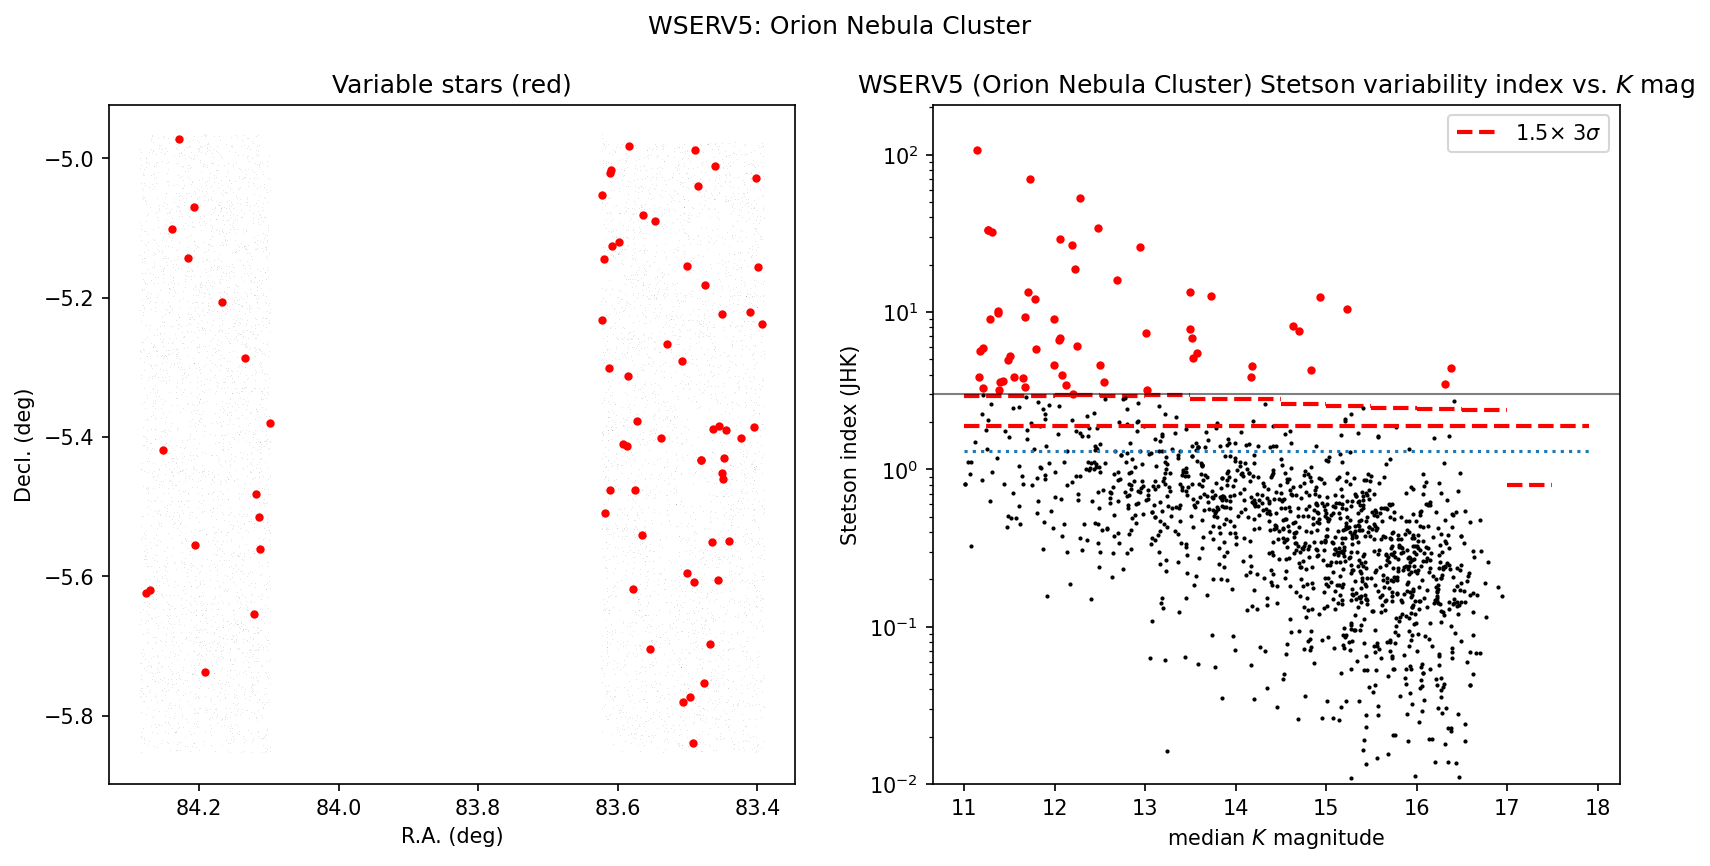

Bin: K=11.0 -- 11.5 [143 objects]
95th percentile Stetson: 1.15
99th percentile Stetson: 1.58
99.7th percentile Stetson: 1.59

Bin: K=11.5 -- 12.0 [131 objects]
95th percentile Stetson: 1.04
99th percentile Stetson: 1.49
99.7th percentile Stetson: 1.59

Bin: K=12.0 -- 12.5 [197 objects]
95th percentile Stetson: 1.02
99th percentile Stetson: 1.46
99.7th percentile Stetson: 1.66

Bin: K=12.5 -- 13.0 [270 objects]
95th percentile Stetson: 0.98
99th percentile Stetson: 1.16
99.7th percentile Stetson: 1.51

Bin: K=13.0 -- 13.5 [376 objects]
95th percentile Stetson: 0.91
99th percentile Stetson: 1.21
99.7th percentile Stetson: 1.45

Bin: K=13.5 -- 14.0 [502 objects]
95th percentile Stetson: 0.74
99th percentile Stetson: 1.17
99.7th percentile Stetson: 1.37

Bin: K=14.0 -- 14.5 [701 objects]
95th percentile Stetson: 0.68
99th percentile Stetson: 1.11
99.7th percentile Stetson: 1.29

Bin: K=14.5 -- 15.0 [943 objects]
95th percentile Stetson: 0.59
99th percentile Stetson: 0.91
99.7th percentile

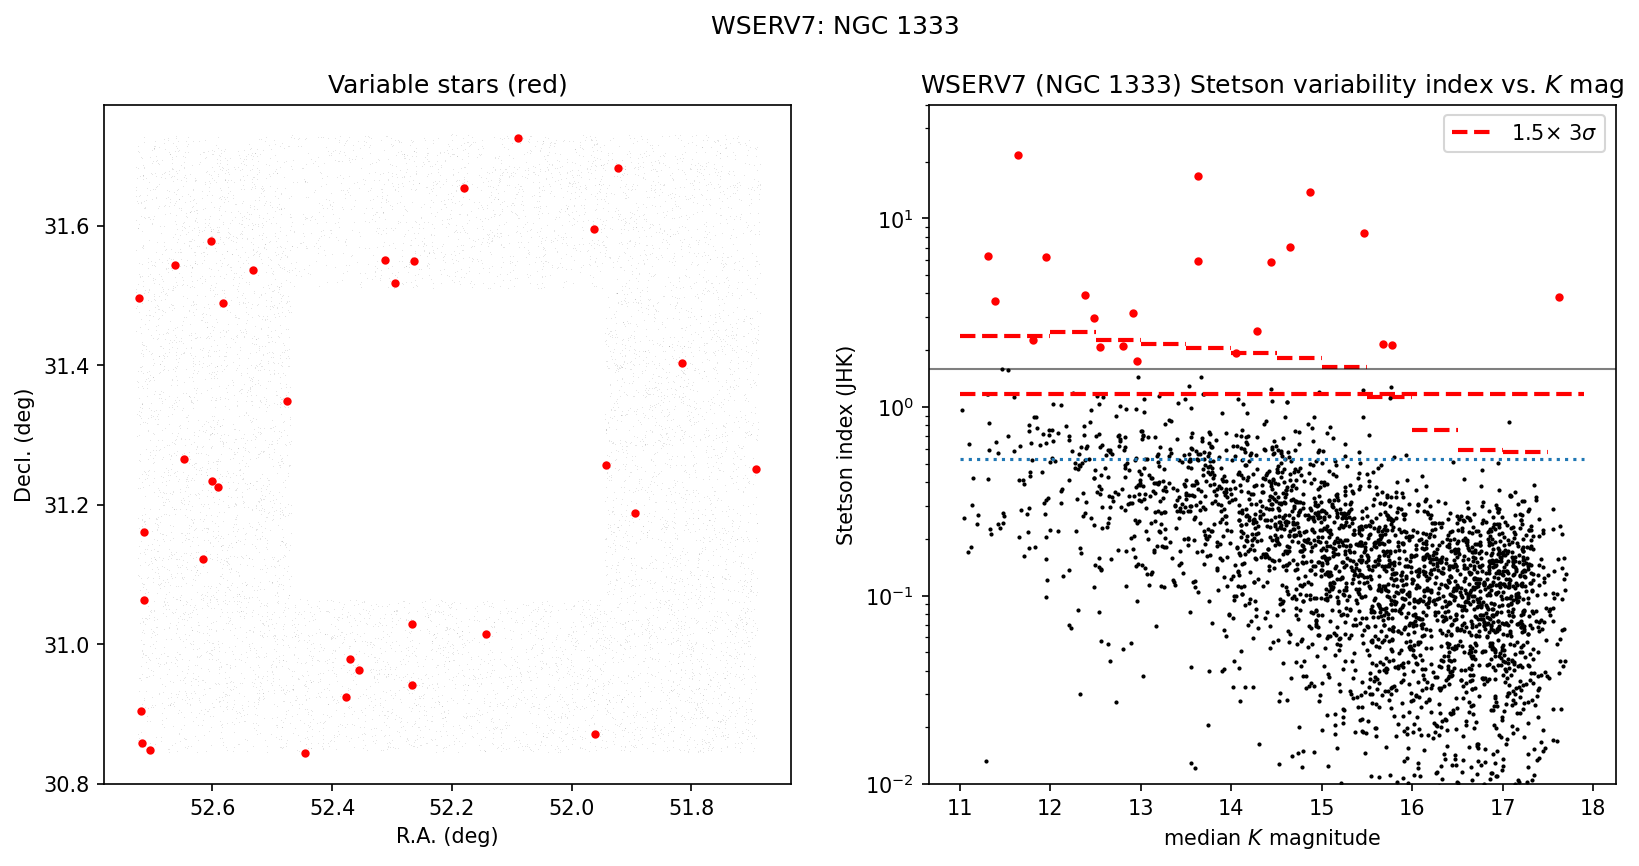

Bin: K=11.0 -- 11.5 [115 objects]
95th percentile Stetson: 1.19
99th percentile Stetson: 1.59
99.7th percentile Stetson: 1.70

Bin: K=11.5 -- 12.0 [109 objects]
95th percentile Stetson: 1.41
99th percentile Stetson: 1.79
99.7th percentile Stetson: 1.89

Bin: K=12.0 -- 12.5 [164 objects]
95th percentile Stetson: 1.22
99th percentile Stetson: 1.61
99.7th percentile Stetson: 1.86

Bin: K=12.5 -- 13.0 [207 objects]
95th percentile Stetson: 1.15
99th percentile Stetson: 1.48
99.7th percentile Stetson: 1.85

Bin: K=13.0 -- 13.5 [270 objects]
95th percentile Stetson: 0.93
99th percentile Stetson: 1.20
99.7th percentile Stetson: 1.32

Bin: K=13.5 -- 14.0 [343 objects]
95th percentile Stetson: 0.89
99th percentile Stetson: 1.23
99.7th percentile Stetson: 1.33

Bin: K=14.0 -- 14.5 [492 objects]
95th percentile Stetson: 0.74
99th percentile Stetson: 1.08
99.7th percentile Stetson: 1.28

Bin: K=14.5 -- 15.0 [670 objects]
95th percentile Stetson: 0.62
99th percentile Stetson: 0.98
99.7th percentile

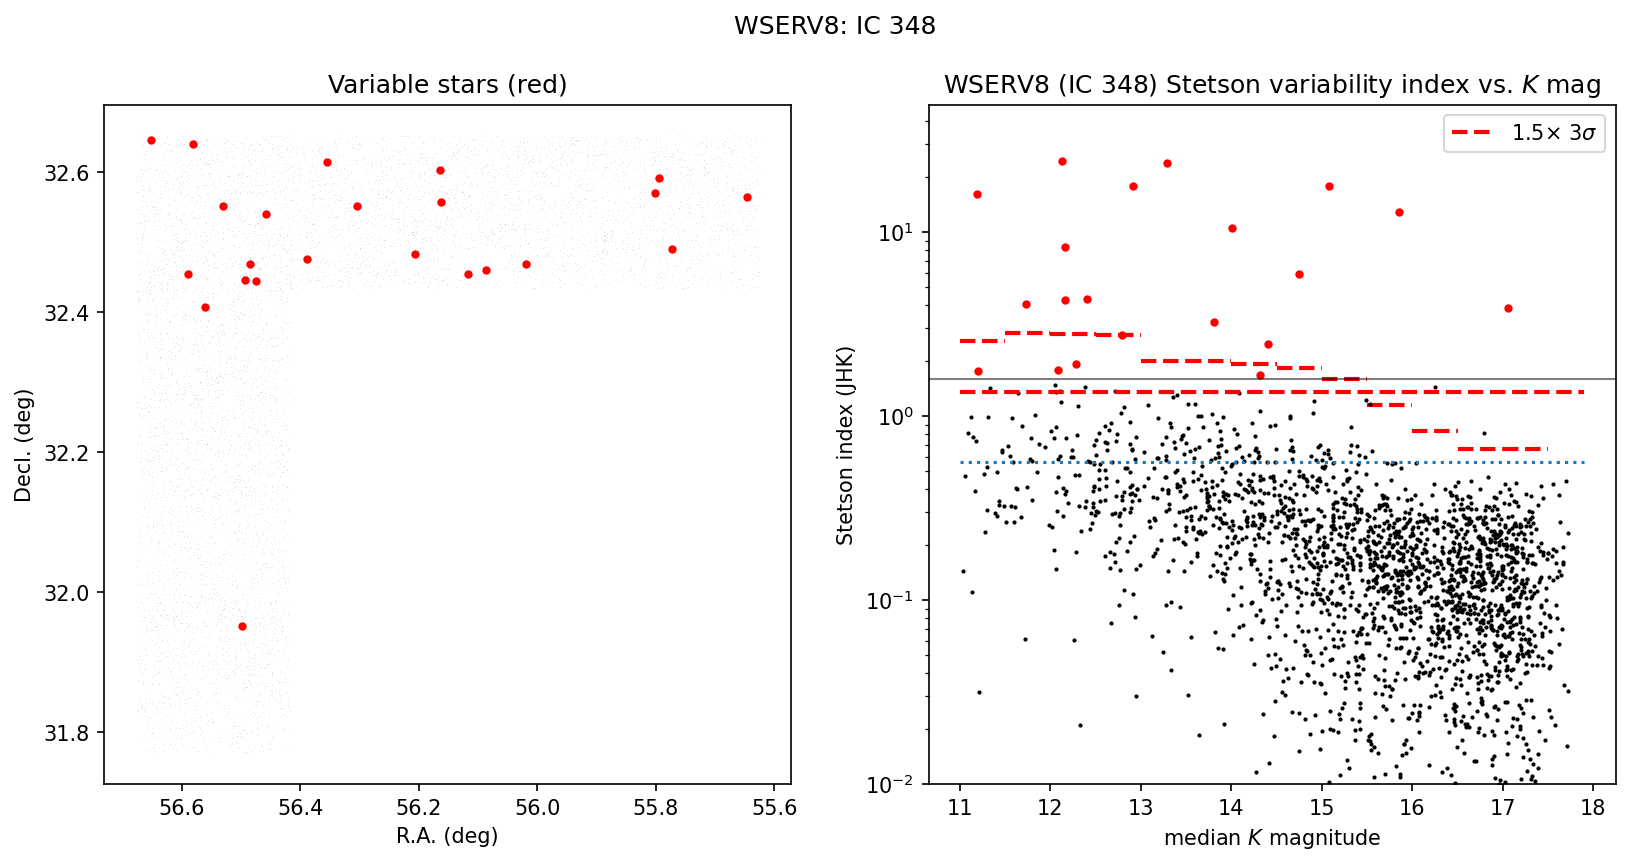

In [87]:
wserv_ids = [1, 5, 7, 8, 11]

# n_obs_list = [130, 120, 171, 85, 110]

n_min_list = [60, 35, 80, 55, 65]
n_max_list = [100, 90, 160, 80, 100]

min_Stetson_list = [2, 3, 1.6, 1.6, 4]

SFR_names = ["Cyg OB7", "Orion Nebula Cluster", "NGC 1333", "IC 348", "Mon R2"]
SFR_dict = {x: y for x, y in zip(wserv_ids, SFR_names)}

# spatial_cut = {}
# spatial_cut[5] = 


for wserv, n_min, n_max, S in list(zip(wserv_ids, n_min_list, n_max_list, min_Stetson_list)):
    if wserv in [5, 7, 8]:
    
        ds = spread[f'wserv{wserv}']

        q0 = sq0(ds, n_min, n_max)
        q1 = sq1(ds, n_min, n_max)
        q2 = sq2(ds, n_min, n_max)

        v0 = sq0_variables(ds, n_min, n_max, Stetson_cutoff=S)
        v1 = sq1_variables(ds, n_min, n_max, Stetson_cutoff=S)
        v2 = sq2_variables(ds, n_min, n_max, Stetson_cutoff=S)

#         min_ra = ds['mean']['RA'].min()
#         max_ra = ds['mean']['RA'].max()
        
#         ra_range = max_ra - min_ra
        
#         ra = ds['mean']['RA']
#         dec = ds['mean']['DEC']
        
#         selection_region = (ra > (min_ra + ra_range/4)) & (ra < (max_ra - ra_range/4))
        
        selection_region = selection_fns[wserv](ds)

        fig, axes = plt.subplots(ncols=2, figsize=(13,6), dpi=150)

        ax, ax2 = axes
#         axes = [ax]

        ax.plot(np.degrees(ds[q0 & ~selection_region]['mean']['RA']), np.degrees(ds[q0 & ~selection_region]['mean']['DEC']), 'k,', alpha=0.1)
        ax.invert_xaxis()

        axes[0].plot(np.degrees(ds[v1 & ~selection_region]['mean']['RA']), np.degrees(ds[v1 & ~selection_region]['mean']['DEC']), 'r.')

        fig.suptitle(f"WSERV{wserv}: {SFR_dict[wserv]}")

        axes[0].set_title("Variable stars (red)")
        axes[0].set_xlabel("R.A. (deg)")
        axes[0].set_ylabel("Decl. (deg)")

#         plt.subplots_adjust(wspace=0)

#         fig2, ax2 = plt.subplots(ncols=1, figsize=(6,6), dpi=150)


#         print(f"WSERV{wserv} Q1 brown dwarf candidates: {np.sum(q1&bd)}")
#         print(f"WSERV{wserv} Q1 brown dwarf candidates that are variable: {np.sum(v1&bd)}")
#         print(f"WSERV{wserv} Q1 variables: {np.sum(v1)}")
#         print()
#         ax.legend()
#         ax.grid(True, alpha=0.5)

        ax2.plot(ds[q2 & ~selection_region]['median']['KAPERMAG3'], ds[q2 & ~selection_region]['variability']['Stetson_JHK'], 'k.', ms=2)
    
        hist, bin_edges = np.histogram(ds[q2 & ~selection_region]['median']['KAPERMAG3'], range=(11,18), bins=(18-11)*2)

        xs = ds[q2 & ~selection_region]['median']['KAPERMAG3']
        ys = ds[q2 & ~selection_region]['variability']['Stetson_JHK']
        x_grid, result_grid_95 = moving_average_percentile(xs, ys, x_range=(11,18), percentile=95)
        x_grid, result_grid_997 = moving_average_percentile(xs, ys, x_range=(11,18), percentile=99.7)
        
        ax2.plot(x_grid, result_grid_95, ':')
        ax2.plot(x_grid, result_grid_997, 'r--', lw=2)
        
        for i in range(len(bin_edges)-1):
            try:
                raw_bin_min = bin_edges[i]
                raw_bin_max = bin_edges[i+1]
                
                bin_size = (raw_bin_max-raw_bin_min)
                
                bin_min = raw_bin_min - bin_size
                bin_max = raw_bin_max + bin_size
                
                print(f"Bin: K={raw_bin_min} -- {raw_bin_max} [{hist[i]+hist[i-1]+hist[i+1]} objects]")

                # give me the range of Stetson indices in this K band selection
                valids = ds[q2 & ~selection_region]
                percentile95 = np.percentile(valids['variability']['Stetson_JHK'][(bin_min < valids['median']['KAPERMAG3']) & (valids['median']['KAPERMAG3'] < bin_max) & (valids['variability']['Stetson_JHK'] < 2)], 95)
                percentile99 = np.percentile(valids['variability']['Stetson_JHK'][(bin_min < valids['median']['KAPERMAG3']) & (valids['median']['KAPERMAG3'] < bin_max) & (valids['variability']['Stetson_JHK'] < 2)], 99)
                percentile997 = np.percentile(valids['variability']['Stetson_JHK'][(bin_min < valids['median']['KAPERMAG3']) & (valids['median']['KAPERMAG3'] < bin_max) & (valids['variability']['Stetson_JHK'] < 2)], 99.7)
                print(f"95th percentile Stetson: {percentile95:.2f}")
                print(f"99th percentile Stetson: {percentile99:.2f}")
                print(f"99.7th percentile Stetson: {percentile997:.2f}")
                print("")

#                 ax2.hlines(percentile95, raw_bin_min, raw_bin_max)
#                 ax2.hlines(percentile99, raw_bin_min, raw_bin_max)
#                 ax2.hlines(percentile997, raw_bin_min, raw_bin_max)
                ax2.hlines(percentile997*1.5, raw_bin_min, raw_bin_max, color='r', lw=2, ls='--', label=r'1.5$\times$ 3$\sigma$' if i==0 else None)
                
                threshold = percentile997*1.5
            except IndexError:
                print("IndexError")
            
#             this_bin = (bin_min < valids['median']['KAPERMAG3'] < bin_max)
            
#             print(this_bin)
#             min_S_bin = 
            
#         ax2.plot(ds[q2 & bd]['median']['KAPERMAG3'], ds[q2 & bd]['variability']['Stetson_JHK'], 'bo', ms=3)
        ax2.plot(ds[q2 & v2 & ~selection_region]['median']['KAPERMAG3'], ds[q2 & v2 & ~selection_region]['variability']['Stetson_JHK'], 'r.')
#         ax2.plot(ds[bd & v2]['median']['KAPERMAG3'], ds[bd & v2]['variability']['Stetson_JHK'], 'mo')
        ax2.semilogy()
        ax2.axhline(S, color='k', lw=1, alpha=0.5)
        ax2.set_ylim(1e-2, None)
        ax2.set_ylabel("Stetson index (JHK)")
        ax2.set_xlabel("median $K$ magnitude")

        ax2.set_title(f"WSERV{wserv} ({SFR_dict[wserv]}) Stetson variability index vs. $K$ mag")
        
        ax2.legend()


        plt.show()


In [28]:
np.histogram(ds[q2 & ~selection_region]['median']['KAPERMAG3'], range=(11,17), bins=(17-11)*2)

(array([ 37,  47,  65,  75, 100, 129, 116, 171, 258, 280, 265,  53]),
 array([11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. ]))

In [43]:
np.percentile?

In [51]:
plt.vlines?

# Applying it (prototype)

Below, I want to **USE** the method above (with the same spatial cuts) to actually **find** the threshold and then find objects **above** it which are also BDs.

In [80]:
lc_dir = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/analysis/prototypes/BD_lcs_v3"

inspect_onc = pd.read_csv(os.path.join(lc_dir, "inspection_onc.csv"), skipinitialspace=True)
inspect_ngc = pd.read_csv(os.path.join(lc_dir, "inspection_ngc.csv"), skipinitialspace=True)
inspect_ic = pd.read_csv(os.path.join(lc_dir, "inspection_ic.csv"), skipinitialspace=True)

approved_sources_onc = inspect_onc['SOURCEID'][inspect_onc['exclude?'] != 'yes']
approved_sources_ngc = inspect_ngc['SOURCEID'][inspect_ngc['exclude?'] != 'yes']
approved_sources_ic = inspect_ic['SOURCEID'][inspect_ic['exclude?'] != 'yes']

approved = {}
approved[5] = approved_sources_onc
approved[7] = approved_sources_ngc
approved[8] = approved_sources_ic

spreadsheet_dir = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/analysis/prototypes"
period_sheet_ic = pd.read_excel(
    os.path.join(spreadsheet_dir, "IC_source_properties_periods_inspected.xlsx")
)
period_sheet_onc = pd.read_excel(
    os.path.join(spreadsheet_dir, "ONC_source_properties_periods_inspected.xlsx")
)
period_sheet_ngc = pd.read_excel(
    os.path.join(spreadsheet_dir, "NGC_source_properties_periods_inspected.xlsx")
)

flags = ['Y', 'Yw', 'N', 'YfY', '?fY', 'YfYw', '?fYw', "YfN", "?fN"]
periodic_flags = [flag for flag in flags if flag[-1] in ('Y', 'w')]

periodic_onc = period_sheet_onc[np.in1d(period_sheet_onc['Periodic?'], periodic_flags)]
periodic_ngc = period_sheet_ngc[np.in1d(period_sheet_ngc['Periodic?'], periodic_flags)]
periodic_ic = period_sheet_ic[np.in1d(period_sheet_ic['Periodic?'], periodic_flags)]

periodic = {}
periodic[5] = periodic_onc
periodic[7] = periodic_ngc
periodic[8] = periodic_ic

WSERV5 Q1 brown dwarf candidates: 237
WSERV5 Q1 brown dwarf candidates that are variable: 63
WSERV5 Q1 variables: 452

IndexError


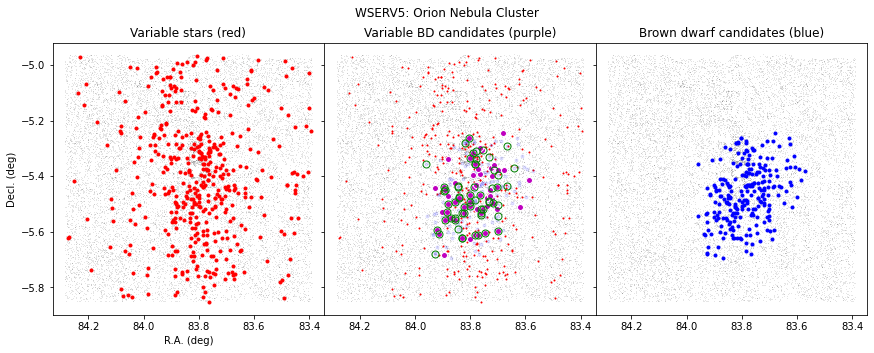

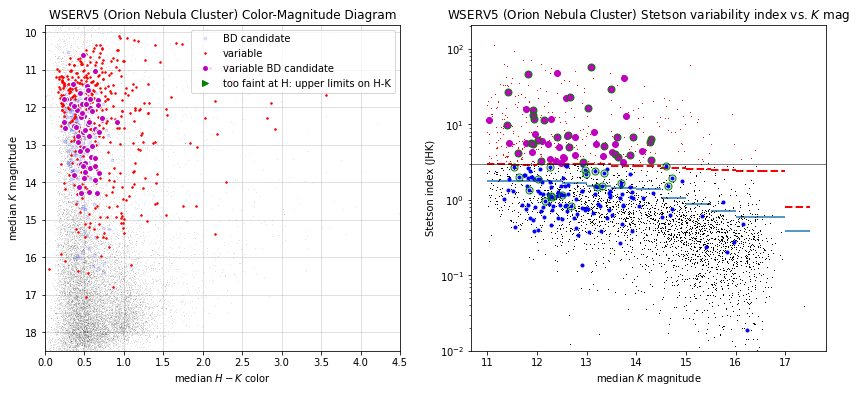

WSERV7 Q1 brown dwarf candidates: 85
WSERV7 Q1 brown dwarf candidates that are variable: 28
WSERV7 Q1 variables: 101



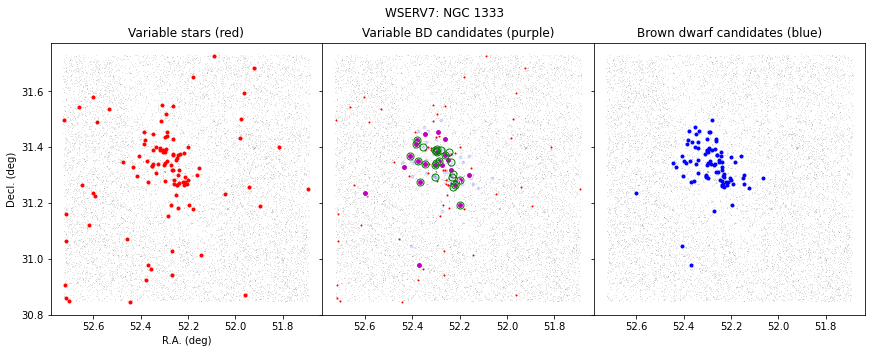

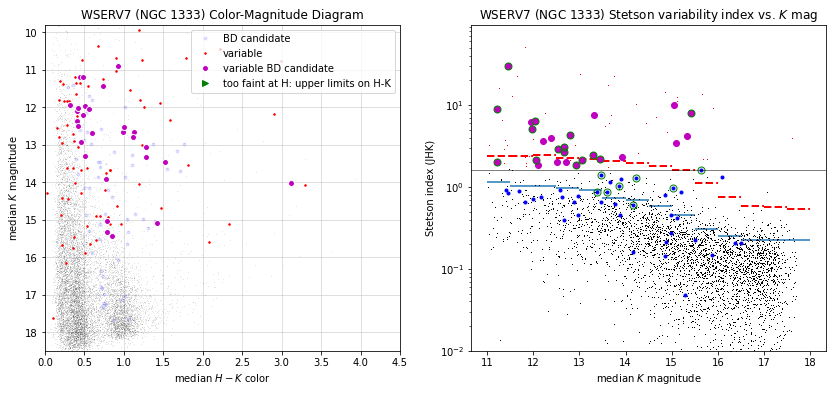

WSERV8 Q1 brown dwarf candidates: 193
WSERV8 Q1 brown dwarf candidates that are variable: 37
WSERV8 Q1 variables: 181



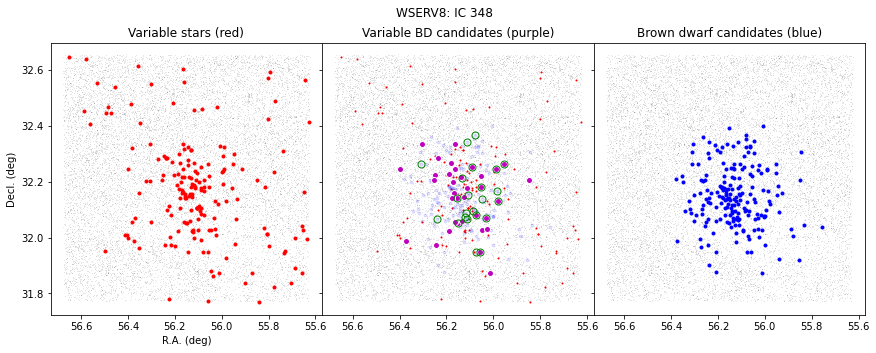

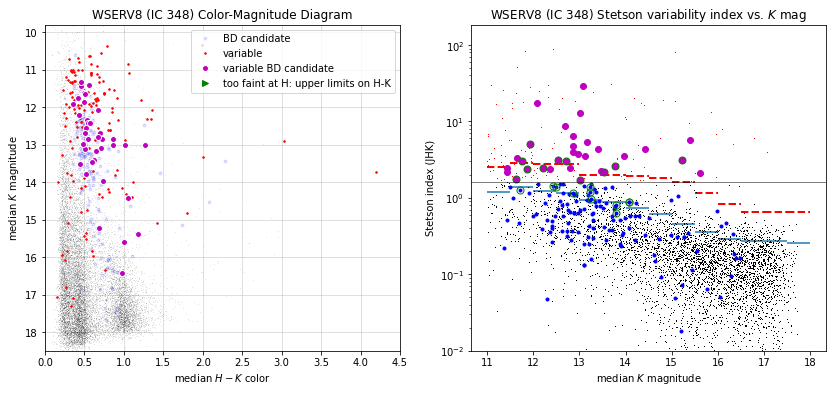

In [88]:
wserv_ids = [1, 5, 7, 8, 11]

# n_obs_list = [130, 120, 171, 85, 110]

n_min_list = [60, 35, 80, 55, 65]
n_max_list = [100, 90, 160, 80, 100]

min_Stetson_list = [2, 3, 1.6, 1.6, 4]

SFR_names = ["Cyg OB7", "Orion Nebula Cluster", "NGC 1333", "IC 348", "Mon R2"]
SFR_dict = {x: y for x, y in zip(wserv_ids, SFR_names)}

for wserv, n_min, n_max, S in list(zip(wserv_ids, n_min_list, n_max_list, min_Stetson_list)):
    if wserv in [5, 7, 8]:
    
        ds = spread[f'wserv{wserv}']

        q0 = sq0(ds, n_min, n_max)
        q1 = sq1(ds, n_min, n_max)
        q2 = sq2(ds, n_min, n_max)

        v0 = sq0_variables(ds, n_min, n_max, Stetson_cutoff=S)
        v1 = sq1_variables(ds, n_min, n_max, Stetson_cutoff=S)
        v2 = sq2_variables(ds, n_min, n_max, Stetson_cutoff=S)

#         bd = simple_BD_select_v2(ds, wserv)
        bd = np.in1d(ds.index, approved[wserv].values)
#         lowmass = np.in1d(ds['SOURCEID'], approved[wserv].value)

        per_bd = np.in1d(ds.index, periodic[wserv].values)
    
        selection_region = selection_fns[wserv](ds)
    


        fig, axes = plt.subplots(ncols=3, figsize=(14.6,5), sharex=True, sharey=True)

        for ax in axes:

            ax.plot(np.degrees(ds[q0]['mean']['RA']), np.degrees(ds[q0]['mean']['DEC']), 'k,', alpha=0.1)
            ax.invert_xaxis()

        axes[0].plot(np.degrees(ds[v1]['mean']['RA']), np.degrees(ds[v1]['mean']['DEC']), 'r.')

        axes[1].plot(np.degrees(ds[v1]['mean']['RA']), np.degrees(ds[v1]['mean']['DEC']), 'r.', ms=2)
        axes[1].plot(np.degrees(ds[q1 & bd]['mean']['RA']), np.degrees(ds[q1 & bd]['mean']['DEC']), 'bo', alpha=0.1, ms=3)
        axes[1].plot(np.degrees(ds[v1 & bd]['mean']['RA']), np.degrees(ds[v1 & bd]['mean']['DEC']), 'mo', markeredgecolor='w', ms=6)
        axes[1].plot(np.degrees(ds[q1 & per_bd]['mean']['RA']), np.degrees(ds[q1 & per_bd]['mean']['DEC']), 'go', markerfacecolor='None', ms=7, mew=1)

        axes[2].plot(np.degrees(ds[q1 & bd]['mean']['RA']), np.degrees(ds[q1 & bd]['mean']['DEC']), 'bo', ms=3)

        fig.suptitle(f"WSERV{wserv}: {SFR_dict[wserv]}")

        axes[0].set_title("Variable stars (red)")
        axes[1].set_title("Variable BD candidates (purple)")
        axes[2].set_title("Brown dwarf candidates (blue)")

        axes[0].set_xlabel("R.A. (deg)")
        axes[0].set_ylabel("Decl. (deg)")

        plt.subplots_adjust(wspace=0)


        # rieke & lebofsky 1985 reddening law
        A_K = 0.112
        A_H = 0.175
        E_HK = A_H - A_K # this is like a slope in color-mag space

#         J_BDlimit = apparent_BD_mags_jhk[wserv][0]
#         H_BDlimit = apparent_BD_mags_jhk[wserv][1]
#         K_BDlimit = apparent_BD_mags_jhk[wserv][2]

        fig2, (ax, ax2) = plt.subplots(ncols=2, figsize=(14,6))

        h = ds['median']['HAPERMAG3']
        k = ds['median']['KAPERMAG3']
        hmk = h-k

        h_e = ds['median']['HAPERMAG3ERR']
        k_e = ds['median']['KAPERMAG3ERR']
        hmk_e = (h_e**2 + k_e**2)**0.5

        hmk_limit = 19 - k
        no_h = np.isnan(ds['median']['HAPERMAG3'])

        ee = (hmk_e<1) & (k_e<1)

#         ax.plot(
#             [H_BDlimit-K_BDlimit, (H_BDlimit-K_BDlimit) + E_HK*30],
#             [K_BDlimit, K_BDlimit + A_K*30],
#             'r--', lw=2,
#             label='$A_V=30$ reddening vector',
#             scalex=False,
#             scaley=False
#         )

        asc = 0.1


        ax.plot(hmk[q0], k[q0], 'k,', alpha=asc)
        ax.plot(hmk[q1 & bd], k[q1 & bd], 'bo', alpha=asc, label='BD candidate', ms=3)
        ax.plot(hmk[v1], k[v1], 'r.', alpha=1, label='variable', ms=3)
        ax.plot(hmk[v1&bd], k[v1&bd], 'mo', alpha=1, label='variable BD candidate', markeredgecolor='w')
        ax.plot(hmk_limit[v1 & no_h], k[v1 & no_h], 'g>', alpha=1, label='too faint at H: upper limits on H-K')

        print(f"WSERV{wserv} Q1 brown dwarf candidates: {np.sum(q1&bd)}")
        print(f"WSERV{wserv} Q1 brown dwarf candidates that are variable: {np.sum(v1&bd)}")
        print(f"WSERV{wserv} Q1 variables: {np.sum(v1)}")
        print()
        ax.legend()
        ax.grid(True, alpha=0.5)

        ax.set_xlabel("median $H-K$ color")
        ax.set_ylabel("median $K$ magnitude")
        ax.set_title(f"WSERV{wserv} ({SFR_dict[wserv]}) Color-Magnitude Diagram")

        ax.set_xlim(0, 4.5)
        ax.set_ylim(18.5, 9.8)
        
        hist, bin_edges = np.histogram(ds[q2 & ~selection_region]['median']['KAPERMAG3'], range=(11,18), bins=(18-11)*2)

        for i in range(len(bin_edges)-1):
            try:
                raw_bin_min = bin_edges[i]
                raw_bin_max = bin_edges[i+1]
                
                bin_size = (raw_bin_max-raw_bin_min)
                
                bin_min = raw_bin_min - bin_size
                bin_max = raw_bin_max + bin_size
                
#                 print(f"Bin: K={raw_bin_min} -- {raw_bin_max} [{hist[i]+hist[i-1]+hist[i+1]} objects]")

                # give me the range of Stetson indices in this K band selection
                valids = ds[q2 & ~selection_region]
                percentile95 = np.percentile(valids['variability']['Stetson_JHK'][(bin_min < valids['median']['KAPERMAG3']) & (valids['median']['KAPERMAG3'] < bin_max) & (valids['variability']['Stetson_JHK'] < 2)], 95)
                percentile99 = np.percentile(valids['variability']['Stetson_JHK'][(bin_min < valids['median']['KAPERMAG3']) & (valids['median']['KAPERMAG3'] < bin_max) & (valids['variability']['Stetson_JHK'] < 2)], 99)
                percentile997 = np.percentile(valids['variability']['Stetson_JHK'][(bin_min < valids['median']['KAPERMAG3']) & (valids['median']['KAPERMAG3'] < bin_max) & (valids['variability']['Stetson_JHK'] < 2)], 99.7)
#                 print(f"95th percentile Stetson: {percentile95:.2f}")
#                 print(f"99th percentile Stetson: {percentile99:.2f}")
#                 print(f"99.7th percentile Stetson: {percentile997:.2f}")
#                 print("")

                ax2.hlines(percentile95, raw_bin_min, raw_bin_max)
#                 ax2.hlines(percentile99, raw_bin_min, raw_bin_max)
#                 ax2.hlines(percentile997, raw_bin_min, raw_bin_max)
                ax2.hlines(percentile997*1.5, raw_bin_min, raw_bin_max, color='r', lw=2, ls='--', label=r'1.5$\times$ 3$\sigma$' if i==0 else None)                
                threshold = percentile997*1.5
            except IndexError:
                print("IndexError")        

        ax2.plot(ds[q2]['median']['KAPERMAG3'], ds[q2]['variability']['Stetson_JHK'], 'k,')
        ax2.plot(ds[q2 & bd]['median']['KAPERMAG3'], ds[q2 & bd]['variability']['Stetson_JHK'], 'bo', ms=3)
        ax2.plot(ds[q2 & v2]['median']['KAPERMAG3'], ds[q2 & v2]['variability']['Stetson_JHK'], 'r,')
        ax2.plot(ds[bd & v2]['median']['KAPERMAG3'], ds[bd & v2]['variability']['Stetson_JHK'], 'mo')
        ax2.plot(ds[q2 & per_bd]['median']['KAPERMAG3'], ds[q2 & per_bd]['variability']['Stetson_JHK'], 'go', markerfacecolor='None', ms=7, mew=1)
        ax2.semilogy()
        ax2.axhline(S, color='k', lw=1, alpha=0.5)
        ax2.set_ylim(1e-2, None)
        ax2.set_ylabel("Stetson index (JHK)")
        ax2.set_xlabel("median $K$ magnitude")

        ax2.set_title(f"WSERV{wserv} ({SFR_dict[wserv]}) Stetson variability index vs. $K$ mag")


        plt.show()


In [84]:
np.percentile?